In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

In [2]:
# format

# dimensions (A4:  8.27 x 11.69 inches)
text_frac = 0.8
abs_pw = 8.27 # pagewidth
abs_pl = 11.69 # pagelength
pw = text_frac * abs_pw
pl = text_frac * abs_pl

# others
dpi=600

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in exp
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in exp


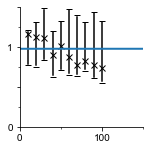

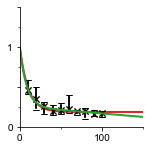

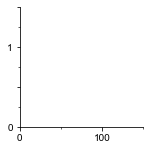

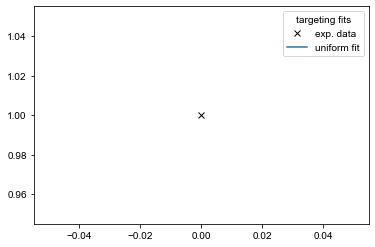

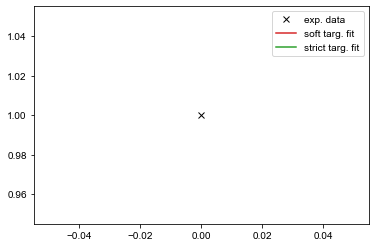

In [3]:
# plot Shemesh et al GFP expression data

fig1, ax0 = plt.subplots(figsize=(pw/3,pw/3))
fig2, ax1 = plt.subplots(figsize=(pw/3,pw/3))
fig3, ax2 = plt.subplots(figsize=(pw/3,pw/3))

from scipy.optimize import curve_fit
import inspect
def res_chi2(xdata, ydata, sigma, popt, fit_func):
    r = ydata - fit_func(xdata, *popt)
    chisq = sum((r / sigma) ** 2)
    return r, chisq
def fit(fitfunc, xdata, ydata, sigma,quartiles,ax,color):
    fitparams = inspect.getfullargspec(fitfunc)[0][1:]
    ndof = len(ydata)-len(fitparams)
    popt, pcov = curve_fit(
        f=fitfunc,
        xdata=xdata,
        ydata=ydata,
        sigma=sigma,
        p0=None, absolute_sigma=False)
    # standard error on the mean is sigma / sqrt(N) with sample size N
    # if we take the median as estimator for the mean then its error is
    sigma_mean = sigma / np.sqrt(9) # 9 samples (neurites) 
    res, chi2 = res_chi2(xdata, ydata, sigma_mean, popt, fitfunc)

    xplot = np.linspace(0,500,5000)    
    #ax.set_title('fit function: '+fitfunc.__name__)
    #ax.plot([1],[10],linestyle='',label=r'$\chi^2/n_{dof}=$%1.2f'%(chi2/ndof))
    ax.plot(xdata, ydata,marker='x',linestyle='',color='Black')
    ax.plot(quartiles.x, quartiles.y,color='Black', marker='_',linestyle='', lw=1.5)
    for x in quartiles.x.unique():
        tmp = quartiles.loc[quartiles.x==x].y.values
        tmp.sort()
        q25, q75 = tmp
        ax.plot([x,x], [q25+0.02,q75-0.02],color='Black', lw=1.5)
    ax.plot(xplot, fitfunc(xplot,*popt), color=color,lw=2)#,label='fit: '+' '.join([param +' %2.5f;'%val for param,val in zip(fitparams, popt)]))

## no targeting case ('uniform')
med_wotargeting = pd.read_csv('../../../metadata/shemesh_scraped_data_supplementary_fig9/David_2_left_median.txt', 
                              delimiter=';',decimal=',',names=['x','y']).round(dict(x=0))
quart_wotargeting = pd.read_csv('../../../metadata/shemesh_scraped_data_supplementary_fig9/David_2_left_quartiles.txt', 
                                delimiter=';',decimal=',',names=['x','y']).round(dict(x=0))
# transform quartile positions into quartile range for error estimation
err_est_wotargeting = pd.DataFrame(quart_wotargeting.groupby(['x'])['y'].diff()).assign(x=quart_wotargeting['x'].values).dropna()

# fit function targeting case (details in metadata/CoChR_expression_level*_slices.ipynb)
def uniform(x, a):
    return np.ones(np.shape(x)) * a

# uniform
fit(fitfunc=uniform, 
    xdata=med_wotargeting.x[1:].values,
    ydata=med_wotargeting.y[1:].values,
    sigma=err_est_wotargeting.y/2, # approx std by (q75-q25)/2
    quartiles=quart_wotargeting,
    ax=ax0, color='tab:blue')

## targeting case
med_wtargeting = pd.read_csv('../../../metadata/shemesh_scraped_data_supplementary_fig9/David_2_right_median.txt', 
                             delimiter=';',decimal=',',names=['x','y']).round(dict(x=0))
quart_wtargeting = pd.read_csv('../../../metadata/shemesh_scraped_data_supplementary_fig9/David_2_right_quartiles.txt', 
                               delimiter=';',decimal=',',names=['x','y']).round(dict(x=0))
# transform quartile positions into quartile range for error estimation
err_est_wtargeting = pd.DataFrame(quart_wtargeting.groupby(['x'])['y'].diff()).assign(x=quart_wtargeting['x'].values).dropna()

# fit function targeting case (details in metadata/CoChR_expression_level*_slices.ipynb)
def exponential_yoffset(x, b, y_off):
    return (1 - y_off) * np.exp(-b*x) + y_off

def exponential_lindecay_yoffset(x, b, m, y_off):
    return (1-y_off) * np.exp(-b*x) - m * x + y_off

# exponential with y-offset
fit(fitfunc=exponential_yoffset, 
    xdata=med_wtargeting.x[1:].values,
    ydata=med_wtargeting.y[1:].values,
    sigma=err_est_wtargeting.y/2, # approx std by (q75-q25)/2
    quartiles=quart_wtargeting,
    ax=ax1, color='tab:red')

# exponential with y-offset and lin decay
fit(fitfunc=exponential_lindecay_yoffset, 
    xdata=med_wtargeting.x[1:].values,
    ydata=med_wtargeting.y[1:].values,
    sigma=err_est_wtargeting.y/2, # approx std by (q75-q25)/2
    quartiles=quart_wtargeting,
    ax=ax1, color='tab:green')

# remove top and right spines
for ax in [ax0,ax1,ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([0,0.5,1,1.5])
    ax.set_yticklabels([0,'',1,''])
    ax.set_yticks([0.25,0.75,1.25], minor=True)
    ax.set_xticks([0,100,200])
    ax.set_xticks([50,150],minor=True)
    ax.set_xlim(0,150)
    ax.set_ylim(0,1.5)
fig1.savefig('plots/GFP_not_targeting.png', dpi=dpi, 
            facecolor='w', edgecolor='w',  
            bbox_inches='tight')
fig2.savefig('plots/GFP_soft_targeting.png', dpi=dpi, 
            facecolor='w', edgecolor='w',  
            bbox_inches='tight')
fig3.savefig('plots/GFP_strict_targeting.png', dpi=dpi, 
            facecolor='w', edgecolor='w',  
            bbox_inches='tight')
plt.show()
plt.figure()
plt.plot([1], marker='x', color='black', linestyle='',label='exp. data')
plt.plot([1],label='uniform fit',color='tab:blue')
plt.legend(title='targeting fits')
plt.savefig('plots/GFP_legend1.png', dpi=dpi, 
            facecolor='w', edgecolor='w',  
            bbox_inches='tight')
plt.show()
plt.figure()
plt.plot([1], marker='x', color='black', linestyle='',label='exp. data')
plt.plot([1],label='soft targ. fit',color='tab:red')
plt.plot([1],label='strict targ. fit',color='tab:green')
plt.legend()
plt.savefig('plots/GFP_legend2.png', dpi=dpi, 
            facecolor='w', edgecolor='w',  
            bbox_inches='tight')

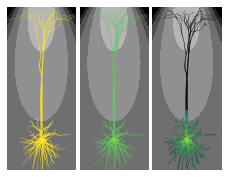

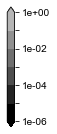

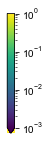

In [4]:
# plot expression inside neurons

fig = plt.figure(constrained_layout=False, figsize=(pw/2,pl*0.32))
gs = fig.add_gridspec(nrows=1, ncols=3, left=0.05, right=0.95,
                        wspace=0.05)
# axes for L5 neuron display
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
axL5_ratio = 308/129

## light and neuron display
cortex_boundaries = { 
    'x': [-300,300],
    'z': [0,1800]
}
cortical_layer_boundaries = [400,800,1200,1600] # L1-2/3, L2/3-4, L4-5, L5-6 (#ToDO: find out real boundaries)

## L23 and L5 response parameters
light_model = 'foutz_et_al2012'
fiber_diameter = 200 #um
fiber_NA = 0.39
light_powers = [1e-5, 1e-4, 1e-3] # mW
light_delay = 1 #ms
light_duration = 30 #ms

light_props = dict(
    NA = fiber_NA, d__um = fiber_diameter,
    mu_s__per_mm = 7.37,
    mu_a__per_mm = 0.1249)

stim_int_conv = 1000/(fiber_diameter/1000/2)**2/np.pi
    
# light profiles
# Foutz optical fiber light source
from neurostim.light_propagation_models import foutz_et_al2012
xx, zz = np.meshgrid(np.arange(cortex_boundaries['x'][0],cortex_boundaries['x'][1]),
                     np.arange(cortex_boundaries['z'][0],cortex_boundaries['z'][1]))
L_prof = foutz_et_al2012(
    x=xx, y=np.zeros(np.shape(xx)), z=zz, power=1, 
    width=light_props['d__um'], NA=light_props['NA'], 
    scatter_coefficient=light_props['mu_s__per_mm'], absorbance_coefficient=light_props['mu_a__per_mm'],
    spreading=True, scattering=True)
# scale bar
#L_prof[500:550,300:400]=1e10
#L_prof[300:500,550:600]=1e10
# normalize light_profile by average output intensity
# 1W/cm2 light power / (pi * diam_in_cm/2)**2
avrg_output_intensity = 1 / (np.pi * (light_props['d__um']/2 * 1e-4)**2)
L_prof /= avrg_output_intensity

# load neuron expression plots
import pickle
def load_collection(hoc_label, ChR2_distribution):
    fname = '../../figdata/fig3_expressionplots_'+hoc_label+'_'+ChR2_distribution+'_newChRdistrib.pickle'
    with open(fname, 'rb') as file:
        return pickle.load(file)
# add L5 neuron to plots
ax0.add_collection(load_collection('L5', ChR2_distribution='uniform'))
ax1.add_collection(load_collection('L5', ChR2_distribution='shemesh_supfig9b_exp_yoff'))
ax2.add_collection(load_collection('L5black', ChR2_distribution='shemesh_supfig9b_exp_lin_yoff'))
ax2.add_collection(load_collection('L5', ChR2_distribution='shemesh_supfig9b_exp_lin_yoff'))

# add light source to all neuron displays
from matplotlib.colors import LogNorm, BoundaryNorm
from matplotlib.cm import Greys_r as cmap
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = truncate_colormap(cmap, minval=0, maxval=0.6)
bounds = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
norm = BoundaryNorm(bounds,ncolors=cmap.N)
for ax in [ax0,ax1,ax2]:
    light_mappapble = ax.pcolormesh(xx,zz*-1,L_prof, shading='nearest',
                  norm=norm, 
                  cmap=cmap)

# set aspect ratio for L5 plots
ax0.set_xlim(*cortex_boundaries['x']) 
ax0.set_ylim(-1*(cortex_boundaries['x'][1]-cortex_boundaries['x'][0])*axL5_ratio,0)
ax1.set_xlim(*cortex_boundaries['x']) 
ax1.set_ylim(-1*(cortex_boundaries['x'][1]-cortex_boundaries['x'][0])*axL5_ratio,0)
ax2.set_xlim(*cortex_boundaries['x']) 
ax2.set_ylim(-1*(cortex_boundaries['x'][1]-cortex_boundaries['x'][0])*axL5_ratio,0)

# turn axes off for neuron plots
for ax in [ax0,ax1,ax2]:
    ax.set_axis_off()
#ax0.plot([-500,0,0],[-2000,-2000,-1500],lw=1,c='red')

fig.savefig('plots/neuron_light_plots.png', dpi=dpi, 
            facecolor='w', edgecolor='w',  
            bbox_inches='tight')

# colorbar light
fig = plt.figure(constrained_layout=False, figsize=(pw/50,pw/3))
ax = fig.add_subplot()                           
ticks=bounds
cbar = fig.colorbar(light_mappapble, cax=ax, ticks=ticks, extend='both')
tick_labels = ['{:5.0e}'.format(x) if idx%2==0 else '' for idx,x in enumerate(ticks)]  # unit: mW/cm2
cbar.ax.set_yticklabels(tick_labels, rotation=0)
fig.savefig('plots/colobar_light_intensity.png', dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')
plt.show()

# ChR density limits from logscale chosen in "generate_neuron_plots.ipynb"
clim_L5  = [13e6,13e9]
from matplotlib.cm import viridis as cmapdens

fig = plt.figure(constrained_layout=False, figsize=(pw/50,pw/3))
ax = fig.add_subplot()
vmin, vmax = clim_L5
normdens = LogNorm(vmin=vmin/vmax, vmax=1)
rand_data = plt.pcolormesh([[1,2],[3,4]],cmap=cmapdens,norm=normdens)
cbar = fig.colorbar(rand_data, cax=ax, orientation='vertical', 
                    extend='min')
#cbar.ax.set_yticks(normdens(np.array([13e7,13e8,13e9])))
#cbar.ax.set_yticklabels(['   1 %','   10 %','   100 %'], rotation=0)
#cbar.ax.set_yticklabels(['0','300','600','900','1200'], rotation='vertical')
#cbar.ax.set_yticklabels(['0','300','600','900','1200'], rotation='vertical')
fig.savefig('plots/colobar_density_lognorm.png',
            facecolor=None, edgecolor=None,  
            bbox_inches='tight',dpi=dpi)
plt.show()

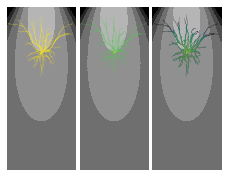

In [5]:
# plot expression inside neurons L23

fig = plt.figure(constrained_layout=False, figsize=(pw/2,pl*0.32))
gs = fig.add_gridspec(nrows=1, ncols=3, left=0.05, right=0.95,
                        wspace=0.05)
# axes for L5 neuron display
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
axL5_ratio = 308/129

## light and neuron display
cortex_boundaries = { 
    'x': [-300,300],
    'z': [0,1800]
}
cortical_layer_boundaries = [400,800,1200,1600] # L1-2/3, L2/3-4, L4-5, L5-6 (#ToDO: find out real boundaries)

light_props = dict(
    NA = 0.22, d__um = 200,
    mu_s__per_mm = 7.37,
    mu_a__per_mm = 0.1249)

## L23 and L5 response parameters
light_model = 'foutz_et_al2012'
fiber_diameter = 200 #um
fiber_NA = 0.39
light_powers = [1e-5, 1e-4, 1e-3] # mW
light_delay = 1 #ms
light_duration = 30 #ms

    
import pickle
def load_collection(hoc_label, ChR2_distribution):
    fname = '../../figdata/fig3_expressionplots_'+hoc_label+'_'+ChR2_distribution+'_newChRdistrib.pickle'
    with open(fname, 'rb') as file:
        return pickle.load(file)
# add L23 neuron to plots
ax0.add_collection(load_collection('L23', ChR2_distribution='uniform'))
ax1.add_collection(load_collection('L23', ChR2_distribution='shemesh_supfig9b_exp_yoff'))
ax2.add_collection(load_collection('L23black', ChR2_distribution='shemesh_supfig9b_exp_lin_yoff'))
ax2.add_collection(load_collection('L23', ChR2_distribution='shemesh_supfig9b_exp_lin_yoff'))

# add light source to all neuron displays
for ax in [ax0,ax1,ax2]:
    light_mappapble = ax.pcolormesh(xx,zz*-1,L_prof, shading='nearest',
                  norm=norm, 
                  cmap=cmap)

# set aspect ratio for L5 plots
ax0.set_xlim(*cortex_boundaries['x']) 
ax0.set_ylim(-1*(cortex_boundaries['x'][1]-cortex_boundaries['x'][0])*axL5_ratio,0)
ax1.set_xlim(*cortex_boundaries['x']) 
ax1.set_ylim(-1*(cortex_boundaries['x'][1]-cortex_boundaries['x'][0])*axL5_ratio,0)
ax2.set_xlim(*cortex_boundaries['x']) 
ax2.set_ylim(-1*(cortex_boundaries['x'][1]-cortex_boundaries['x'][0])*axL5_ratio,0)

# turn axes off for neuron plots
for ax in [ax0,ax1,ax2]:
    ax.set_axis_off()
#ax0.plot([-500,0,0],[-2000,-2000,-1500],lw=1,c='red')

fig.savefig('plots/neuron_light_plots_L23.png', dpi=dpi, 
            facecolor='w', edgecolor='w',  
            bbox_inches='tight')

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


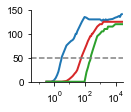

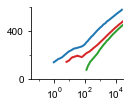

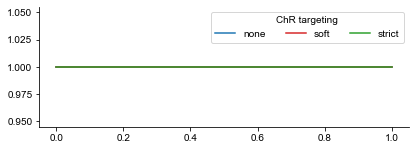

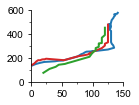

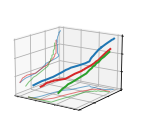

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


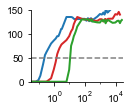

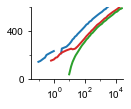

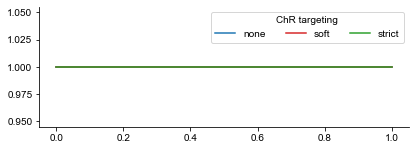

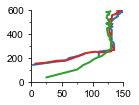

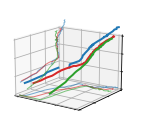

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


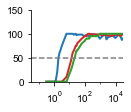

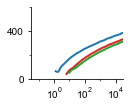

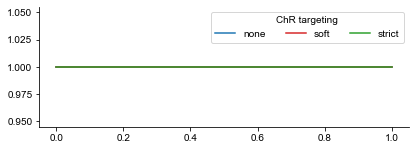

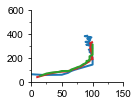

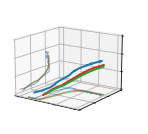

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


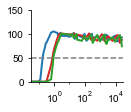

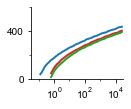

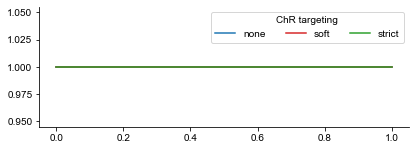

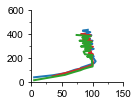

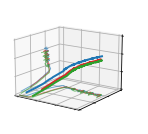

In [6]:
# lineplots peak response and response radius -- 130 um2 ChR density -- L5 neuron
import matplotlib
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
from neurostim.opt_res_analysis import *
# load datasets
# take L5 from simulations on 2.08.2022
raw_df = pd.read_hdf('../../../data/2023-02-27_newChRdistrib/all_data_man.hdf')
avrg_df = pd.DataFrame(avrg_angles(raw_df)['AP_count'])
df = find_xAPCs_over_light_pwrs(avrg_df, longform=False)
df_long = find_xAPCs_over_light_pwrs(avrg_df, longform=True)

# reduce df to relevant parameters
# select parameter set to plot:
light_model = 'foutz_et_al2012'
ChR_expr_lvl = 13e9
stim_duration = 200
diam = 200
NA = 0.22

df_red = df.loc[:,light_model,:,ChR_expr_lvl,diam,NA,stim_duration]
df_red = df_red.reset_index().set_index(["hoc_file","chanrhod_distribution"])
#apply response_pattern = 1 (=central) if response peak offset is below 50um and if neuron responds
df_red['response_pattern'] = (df_red.x_APCmax<50) * (df_red.APCmax>0) * 1

def plot(neuron, df_red, label):
    
    fig, ax1 = plt.subplots(figsize=(pw/4,pw/5))

    dfplot = df_red.loc[neuron,'uniform']
    ax1.plot(dfplot.light_power*stim_int_conv, dfplot.APCmax, label=neuron, color='tab:blue',lw=2)
    # thick line for central regime
    #ax1.plot(dfplot.loc[dfplot.response_pattern==1].light_power, dfplot.loc[dfplot.response_pattern==1].APCmax, label=neuron, color='tab:blue',lw=3)
    dfplot = df_red.loc[neuron,'shemesh_supfig9b_exp_yoff']
    ax1.plot(dfplot.light_power*stim_int_conv, dfplot.APCmax, label=neuron, color='tab:red',lw=2)
    # thick line for central regime
    #ax1.plot(dfplot.loc[dfplot.response_pattern==1].light_power, dfplot.loc[dfplot.response_pattern==1].APCmax, label=neuron, color='tab:red',lw=3)
    dfplot = df_red.loc[neuron,'shemesh_supfig9b_exp_lin_yoff']
    ax1.plot(dfplot.light_power*stim_int_conv, dfplot.APCmax, label=neuron, color='tab:green',lw=2)
    # thick line for central regime
    #ax1.plot(dfplot.loc[dfplot.response_pattern==1].light_power, dfplot.loc[dfplot.response_pattern==1].APCmax, label=neuron, color='tab:green',lw=3)

    ax1.set_xscale('log')
    ax1.set_ylim(0,30)
    ax1.set_xlim(1e-6*stim_int_conv,1*stim_int_conv)
    xticks = [1, 100, 10000]
    ax1.set_xticks(xticks)
    minorxticks = [0.1, 10, 1000]
    ax1.set_xticks(minorxticks, minor=True)
    ax1.set_xticklabels([], minor=True)
    #ax1.ticklabel_format(axis='x', style='sci')
    ax1.set_yticks([0,10,20,30])
    ax1.set_yticklabels([0,50,100,150]) # Hz
    #ax1.set_yticks([10,30], minor=True)
    ax1.axhline(y=10, color="gray", linestyle='dashed')
    #ax1.axhline(y=20, color="gray", linestyle='dashed')
    plt.savefig("plots/pr_lp_"+label+".png", dpi=dpi,transparent=True, edgecolor='w',  
                bbox_inches='tight')
    plt.show()

    fig, ax2 = plt.subplots(figsize=(pw/4,pw/5))

    dfplot = df_red.loc[neuron,'uniform']
    ax2.plot(dfplot.light_power*stim_int_conv, dfplot.x_APC50, label=neuron, color='tab:blue',lw=2)
    # thick line for central regime
    #ax2.plot(dfplot.loc[dfplot.response_pattern==1].light_power, dfplot.loc[dfplot.response_pattern==1].x_APC50, label=neuron, color='tab:blue',lw=3)
    dfplot = df_red.loc[neuron,'shemesh_supfig9b_exp_yoff']
    ax2.plot(dfplot.light_power*stim_int_conv, dfplot.x_APC50, label=neuron, color='tab:red',lw=2)
    # thick line for central regime
    #ax2.plot(dfplot.loc[dfplot.response_pattern==1].light_power, dfplot.loc[dfplot.response_pattern==1].x_APC50, label=neuron, color='tab:red',lw=3)
    dfplot = df_red.loc[neuron,'shemesh_supfig9b_exp_lin_yoff']
    ax2.plot(dfplot.light_power*stim_int_conv, dfplot.x_APC50, label=neuron, color='tab:green',lw=2)
    # thick line for central regime
    #ax2.plot(dfplot.loc[dfplot.response_pattern==1].light_power, dfplot.loc[dfplot.response_pattern==1].x_APC50, label=neuron, color='tab:green',lw=3)

    ax2.set_xscale('log')
    ax2.set_ylim(0,600)
    ax2.set_xlim(1e-6*stim_int_conv,1*stim_int_conv)
    xticks = [1, 100, 10000]
    ax2.set_xticks(xticks)
    minorxticks = [0.1, 10, 1000]
    ax2.set_xticks(minorxticks, minor=True)
    ax2.set_xticklabels([], minor=True)
    ax2.set_yticks([0,400])
    ax2.set_yticks([200,600], minor=True)
    #ax2.legend()
    plt.savefig("plots/rr_lp_"+label+".png", dpi=dpi,transparent=True, edgecolor='w',  
                bbox_inches='tight')

    fig, ax5 = plt.subplots(figsize=(pw,pw/3))
    ax5.plot([1,1], label='none', color='tab:blue')
    ax5.plot([1,1], label='soft', color='tab:red')
    ax5.plot([1,1], label='strict', color='tab:green')
    ax5.legend(ncol=3, title='ChR targeting')
    plt.savefig('plots/legend.png', dpi=dpi)


    # plot neural response strength vs spatial extent
    fig, ax = plt.subplots(figsize=(pw/4,pw/5))

    dfplot = df_red.loc[neuron,'uniform']
    ax.plot(dfplot.APCmax, dfplot.x_APC50, color='tab:blue',lw=2)
    dfplot = df_red.loc[neuron,'shemesh_supfig9b_exp_yoff']
    ax.plot(dfplot.APCmax, dfplot.x_APC50, color='tab:red',lw=2)
    dfplot = df_red.loc[neuron,'shemesh_supfig9b_exp_lin_yoff']
    ax.plot(dfplot.APCmax, dfplot.x_APC50, color='tab:green',lw=2)

    ax.set_ylim(0,600)
    ax.set_xlim(0,30)
    ax.set_xticks([0,10,20,30])
    ax.set_xticklabels([0,50,100,150]) # Hz
    ax.set_xticks([5,15,25], minor=True)
    ax.set_yticks([0,200,400,600])
    ax.set_yticks([100,300,500], minor=True)
    plt.savefig("plots/rr_pr_"+label+'_new'+".png", dpi=dpi,transparent=True, edgecolor='w',  
                bbox_inches='tight')


    def line3d(dfplot, color, label, ax):
        log_lps = np.log10(dfplot.light_power.values)
        ax.plot(xs=log_lps, ys=dfplot.APCmax, zs=dfplot.x_APC50, zdir='z', label=label, lw=2, color=color)
        ax.plot(xs=[np.log10(1e-6)]*len(log_lps), ys=dfplot.APCmax, zs=dfplot.x_APC50, zdir='z', label=label, lw=1, color=color, alpha=0.6)
        ax.plot(xs=log_lps, ys=dfplot.APCmax, zs=[0]*len(dfplot.x_APC50), zdir='z', label=label, lw=1, color=color, alpha=0.6)
        return ax
    ax = plt.figure(figsize=(pw/3,pw/3)).add_subplot(projection='3d')
    ax = line3d(df_red.loc[neuron,'uniform'], color='tab:blue', label='none', ax=ax) 
    ax = line3d(df_red.loc[neuron,'shemesh_supfig9b_exp_yoff'], color='tab:red', label='soft', ax=ax) 
    ax = line3d(df_red.loc[neuron,'shemesh_supfig9b_exp_lin_yoff'], color='tab:green', label='strict', ax=ax) 
    # Make legend, set axes limits and labels
    #ax.legend()
    #ax.set_ylabel('light power')
    #ax.set_zlabel('peak response')
    #ax.set_xlabel('response radius')
    #ax.set_xlim()
    # tick placement and limits collide in matplotlib 3d plots and lead to weird results
    ax.set_ylim(0,30)
    ax.set_zlim(0,600)
    ax.set_xticks(np.log10([1e-6,1e-4,1e-2,1e-0]))

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # Customize the view angle
    ax.view_init(elev=15., azim=-55)

    plt.savefig("plots/3D_"+label+".png", dpi=dpi,transparent=True, edgecolor=None,  
                bbox_inches='tight')
    plt.show()
plot(neuron='L5', df_red=df_red, label='L5_ChRdens130')

# lineplots peak response and response radius -- 1300 um2 ChR density (higher density) -- L5 neuron
# take L5 from simulations on 2.08.2022
raw_df = pd.read_hdf('../../../data/2023-03-03_newChRdistrib_higherChRexpression/all_data_man2.hdf')
avrg_df = pd.DataFrame(avrg_angles(raw_df)['AP_count'])
df = find_xAPCs_over_light_pwrs(avrg_df, longform=False)
df_long = find_xAPCs_over_light_pwrs(avrg_df, longform=True)
# select parameter set to plot:
light_model = 'foutz_et_al2012'
ChR_expr_lvl = 13e10
stim_duration = 200
diam = 200
NA = 0.22
df_red = df.loc[:,light_model,:,ChR_expr_lvl,diam,NA,stim_duration]
df_red = df_red.reset_index().set_index(["hoc_file","chanrhod_distribution"])
#apply response_pattern = 1 (=central) if response peak offset is below 50um and if neuron responds
df_red['response_pattern'] = (df_red.x_APCmax<50) * (df_red.APCmax>0) * 1
plot(neuron='L5', df_red=df_red, label='L5_ChRdens1300')

# lineplots peak response and response radius -- 130 um2 ChR density -- L23 neuron
# take L23 from simulations on 2.08.2022
raw_df = pd.read_hdf('../../../data/2023-02-27_newChRdistrib/all_data_man.hdf')
avrg_df = pd.DataFrame(avrg_angles(raw_df)['AP_count'])
df = find_xAPCs_over_light_pwrs(avrg_df, longform=False)
df_long = find_xAPCs_over_light_pwrs(avrg_df, longform=True)
# select parameter set to plot:
light_model = 'foutz_et_al2012'
ChR_expr_lvl = 13e9
stim_duration = 200
diam = 200
NA = 0.22
df_red = df.loc[:,light_model,:,ChR_expr_lvl,diam,NA,stim_duration]
df_red = df_red.reset_index().set_index(["hoc_file","chanrhod_distribution"])
#apply response_pattern = 1 (=central) if response peak offset is below 50um and if neuron responds
df_red['response_pattern'] = (df_red.x_APCmax<50) * (df_red.APCmax>0) * 1
plot(neuron='L23', df_red=df_red, label='L23_ChRdens130')

# lineplots peak response and response radius -- 1300 um2 ChR density (higher density) -- L23 neuron
# take L23 from simulations on 2.08.2022
raw_df = pd.read_hdf('../../../data/2023-03-03_newChRdistrib_higherChRexpression/all_data_man2.hdf')
avrg_df = pd.DataFrame(avrg_angles(raw_df)['AP_count'])
df = find_xAPCs_over_light_pwrs(avrg_df, longform=False)
df_long = find_xAPCs_over_light_pwrs(avrg_df, longform=True)
# select parameter set to plot:
light_model = 'foutz_et_al2012'
ChR_expr_lvl = 13e10
stim_duration = 200
diam = 200
NA = 0.22
df_red = df.loc[:,light_model,:,ChR_expr_lvl,diam,NA,stim_duration]
df_red = df_red.reset_index().set_index(["hoc_file","chanrhod_distribution"])
#apply response_pattern = 1 (=central) if response peak offset is below 50um and if neuron responds
df_red['response_pattern'] = (df_red.x_APCmax<50) * (df_red.APCmax>0) * 1
plot(neuron='L23', df_red=df_red, label='L23_ChRdens1300')

In [7]:
from neurostim.opt_res_analysis import prepare_df_for_evaluation, eval_spatial_resolution
df_sp_profs = pd.read_hdf('../../../data/2023-06-05_10spikes_L5L23/all_data.hdf')
tmp = []
for ChR_expr in [13e9, 13e10]:
    df_red, df_lp_lookup, failed = prepare_df_for_evaluation(df_sp_profs, defaults_to_reduce=dict(light_model='foutz_et_al2012',
                                                                                              chanrhod_expression=ChR_expr,
                                                                                              stim_duration=200))
    rsc, failed_ps = eval_spatial_resolution(df_red)
    rsc['chanrhod_expression'] = ChR_expr
    tmp.append(rsc)
rsc = pd.concat(tmp).reset_index().set_index(
    ['hoc_file', 'chanrhod_distribution', 'fiber_diameter', 'fiber_NA',
       'APC_desired', 'chanrhod_expression'])

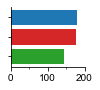

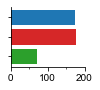

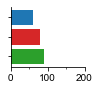

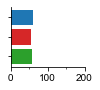

In [8]:
for neuron in ['L5', 'L23']:
    for ChRexpr in [13e9, 13e10]:
        ChRdist = ['uniform', 'shemesh_supfig9b_exp_yoff', 'shemesh_supfig9b_exp_lin_yoff']
        diam = 200
        NA = 0.22
        APC_desired = 10
        dfplot = rsc.loc[neuron,ChRdist,diam,NA, APC_desired, ChRexpr].x_APC50.reset_index()
        # Create horizontal bars
        fig, ax = plt.subplots(figsize=(pw/5,pw/6))
        ax.barh(y=dfplot.chanrhod_distribution, width=dfplot.x_APC50, color=['tab:green','tab:red','tab:blue'])
        ax.set_yticklabels([])
        ax.set_xticks([0,100,200])
        ax.set_xticks([50,150],minor=True)
        fig.savefig(''.join(['plots/summary_',neuron,'_',str(ChRexpr),'.png']), dpi=dpi, 
            facecolor=None, edgecolor=None,  
            bbox_inches='tight')

In [9]:
rsc.loc[neuron,'uniform',diam,NA, APC_desired, ChRexpr].x_APC50

59.05172413793103

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


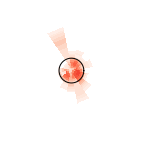

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


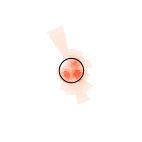

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


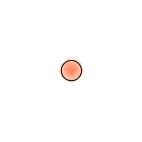

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


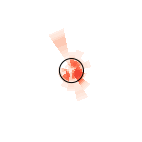

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


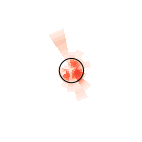

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


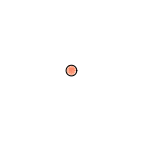

________________________ L23 profiles ______________
APC: 10 -- expr_lvl: 13000000000.0chr distrib: uniform


/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


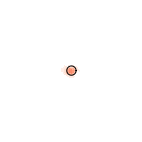

APC: 10 -- expr_lvl: 13000000000.0chr distrib: shemesh_supfig9b_exp_yoff


/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


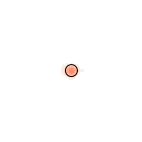

APC: 10 -- expr_lvl: 13000000000.0chr distrib: shemesh_supfig9b_exp_lin_yoff


/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


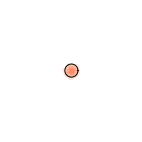

APC: 10 -- expr_lvl: 130000000000.0chr distrib: uniform


/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


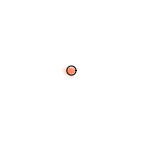

APC: 10 -- expr_lvl: 130000000000.0chr distrib: shemesh_supfig9b_exp_yoff


/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


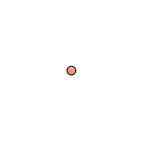

APC: 10 -- expr_lvl: 130000000000.0chr distrib: shemesh_supfig9b_exp_lin_yoff


/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))


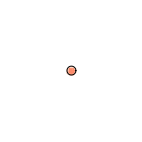

In [12]:
# plotting spatial profiles

#df_sp_profs = pd.read_hdf('../../../data/2023-03-03_10spikes_higherChRexpression/all_data2.hdf')
# loaded hdf file with conda env "pdtables" and saved it as pickle to load in here
# tried that, did not work, saved in csv
#df_sp_profs = pd.read_csv('../../../data/2023-03-03_10spikes_higherChRexpression/all_data.csv').set_index(
#    ['hoc_file', 'light_model','chanrhod_distribution', 'chanrhod_expression', 'fiber_diameter', 'fiber_NA', 'stim_duration [ms]','APC_desired'])
df_sp_profs = pd.read_hdf('../../../data/2023-06-05_10spikes_L5L23/all_data.hdf')
from neurostim.polarmaps import simple_polar_map
light_model = 'foutz_et_al2012'
stim_duration = 200
diam = 200
NA = 0.22

light_powers_APC10_L5 = []
light_powers_APC10_L23 = []

for APC_desired in [10]:
    for expression_lvl_label, expression_lvl in zip(['13e9','13e10'],[13e9, 13e10]):
        for chr_distrib in ['uniform','shemesh_supfig9b_exp_yoff','shemesh_supfig9b_exp_lin_yoff']:
            # select relevant data from data frame
            L5_data = df_sp_profs.loc['L5',light_model,chr_distrib,expression_lvl,diam, NA, stim_duration, APC_desired]
            lp = L5_data.light_power.unique()
            assert len(lp)==1, "found several light powers in a slice of dataframe that should only contain one light power"
            lp = lp[0]
            if APC_desired == 10:
                light_powers_APC10_L5.append(lp)
            # convert relevant columns to float as csv format saves everything as a str
            L5_data = L5_data.reset_index()[['radius [um]','angle [rad]','AP_count']].astype(float)
            # mask all values at 0 to be displayed white
            L5_data.loc[(L5_data.AP_count==0),'AP_count'] = np.nan
            cmap = matplotlib.cm.get_cmap('Reds')
            cmap.set_bad("white")

            fig = plt.figure(constrained_layout=False, figsize=(pw/2.8,pw/2.8))
            gs = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.95,
                                    wspace=0.05)
            ax = fig.add_subplot(gs[0,0], projection="polar")
            ax, mappable = simple_polar_map(
                data=L5_data,
                plot_col='AP_count',
                cmap= cmap,
                ax=ax,
                vmin=0,
                vmax=25)
            resp_space_const = rsc.loc['L5',chr_distrib,diam,NA, APC_desired, expression_lvl].x_APC50
            angles = np.linspace(0,2*np.pi,1000)
            ax.plot(angles,[resp_space_const]*len(angles), color='black', lw=1)
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticks([])
            ax.set_yticklabels([])
            ax.spines['polar'].set_visible(False)
            ax.grid()
            fig.savefig('plots/spatial_response_L5_APC'+str(APC_desired)+'_expression'+expression_lvl_label+'_distrib_'+str(chr_distrib)+'__'+'lp_'+str(lp)+'.png', dpi=dpi, 
                        facecolor=None, edgecolor=None,  
                        bbox_inches='tight')
            plt.show()
print('________________________ L23 profiles ______________')
for APC_desired in [10]:
    for expression_lvl_label, expression_lvl in zip(['13e9','13e10'],[13e9, 13e10]):
        for chr_distrib in ['uniform','shemesh_supfig9b_exp_yoff','shemesh_supfig9b_exp_lin_yoff']:
            print("APC: "+str(APC_desired)+' -- expr_lvl: '+str(expression_lvl)+'chr distrib: '+chr_distrib)
            # select relevant data from data frame
            L23_data = df_sp_profs.loc['L23',light_model,chr_distrib,expression_lvl,diam, NA, stim_duration, APC_desired]
            lp = L23_data.light_power.unique()
            assert len(lp)==1, "found several light powers in a slice of dataframe that should only contain one light power"
            lp = lp[0]
            if APC_desired == 10:
                light_powers_APC10_L23.append(lp)
            # convert relevant columns to float as csv format saves everything as a str
            L23_data = L23_data.reset_index()[['radius [um]','angle [rad]','AP_count']].astype(float)
            # mask all values at 0 to be displayed white
            L23_data.loc[(L23_data.AP_count==0),'AP_count'] = np.nan
            cmap = matplotlib.cm.get_cmap('Reds')
            cmap.set_bad("white")

            fig = plt.figure(constrained_layout=False, figsize=(pw/2.8,pw/2.8))
            gs = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.95,
                                    wspace=0.05)
            ax = fig.add_subplot(gs[0,0], projection="polar")
            ax, mappable = simple_polar_map(
                data=L23_data,
                plot_col='AP_count',
                cmap= cmap,
                ax=ax,
                vmin=0,
                vmax=25)
            resp_space_const = rsc.loc['L23',chr_distrib,diam,NA, APC_desired, expression_lvl].x_APC50
            angles = np.linspace(0,2*np.pi,1000)
            ax.plot(angles,[resp_space_const]*len(angles), color='black', lw=1)
            ax.set_xticks([])
            ax.set_xticklabels([])
            ax.set_yticks([])
            ax.set_yticklabels([])
            ax.spines['polar'].set_visible(False)
            ax.grid()
            fig.savefig('plots/spatial_response_L23_APC'+str(APC_desired)+'_expression'+expression_lvl_label+'_distrib_'+str(chr_distrib)+'__'+'lp_'+str(lp)+'.png', dpi=dpi, 
                        facecolor=None, edgecolor=None,  
                        bbox_inches='tight')
            plt.show()

In [16]:
len(df_sp_profs.reset_index()['angle [rad]'].unique())

16

In [11]:
ls ../../../data/2023-03-03*

../../../data/2023-03-03_10spikes_higherChRexpression:
all_data.csv

../../../data/2023-03-03_newChRdistrib_higherChRexpression:
all_data_man2.hdf  all_data_man.hdf
